In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics, svm
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import norm
from xgboost import plot_importance
from pandas import DataFrame
from keras.models import Sequential  
from keras.layers import Bidirectional, LSTM, Dense  
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Input, Dropout
from tensorflow.keras.models import Model

In [2]:
# 本模块用于定义所用各种模型的类
# 定义 RNN 模型
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input):
        out, _ = self.rnn(input)
        out = self.fc(out[:, -1, :])  # 使用最后一个时间步的输出进行预测
        return out

# 定义 GRU 模型
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input):
        out, _ = self.gru(input)
        out = self.fc(out[:, -1, :])
        return out

# 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input):
        out, _ = self.lstm(input)
        out = self.fc(out[:, -1, :])
        return out

# 定义 BI_LSTM 模型
class BILSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BILSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.bilstm = nn.LSTM(input_size, hidden_size, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    
    def forward(self, input):
        out, _ = self.bilstm(input)
        out = self.fc(out[:, -1, :])  # 使用最后一个时间步的输出进行预测
        return out

 model: RNN
Epoch [20/100], Loss: 0.0396
Epoch [40/100], Loss: 0.0209
Epoch [60/100], Loss: 0.0048
Epoch [80/100], Loss: 0.0031
Epoch [100/100], Loss: 0.0028


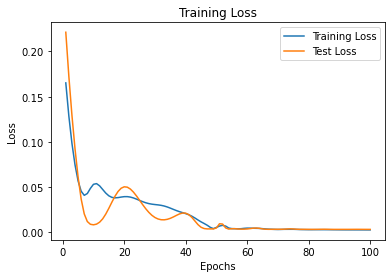

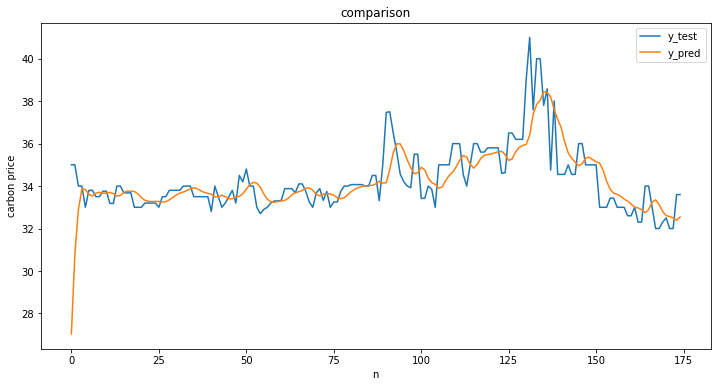

 model: GRU
Epoch [20/100], Loss: 0.0478
Epoch [40/100], Loss: 0.0287
Epoch [60/100], Loss: 0.0212
Epoch [80/100], Loss: 0.0141
Epoch [100/100], Loss: 0.0047


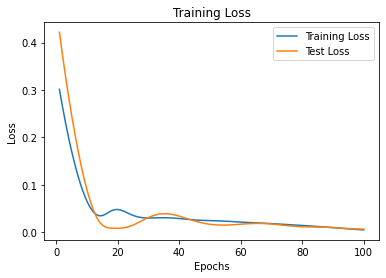

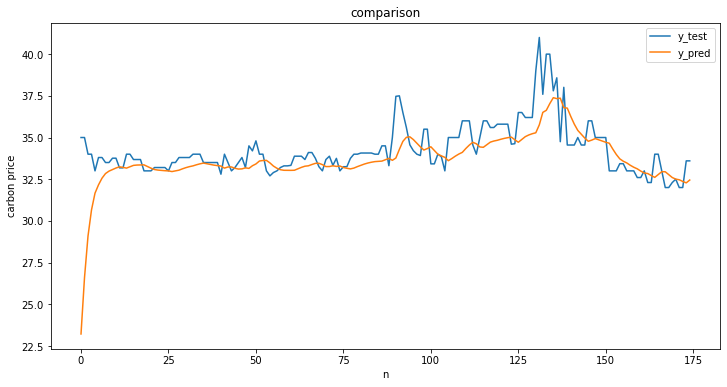

 model: LSTM
Epoch [20/100], Loss: 0.0486
Epoch [40/100], Loss: 0.0298
Epoch [60/100], Loss: 0.0223
Epoch [80/100], Loss: 0.0081
Epoch [100/100], Loss: 0.0060


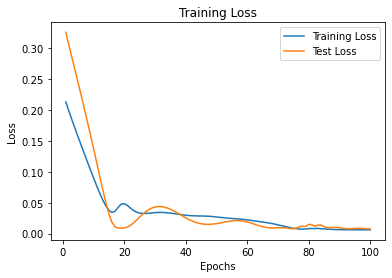

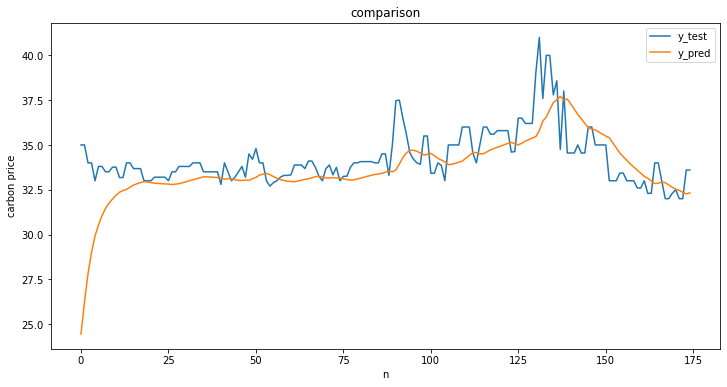

 model: BiLSTM
Epoch [20/100], Loss: 0.0393
Epoch [40/100], Loss: 0.0243
Epoch [60/100], Loss: 0.0131
Epoch [80/100], Loss: 0.0037
Epoch [100/100], Loss: 0.0023


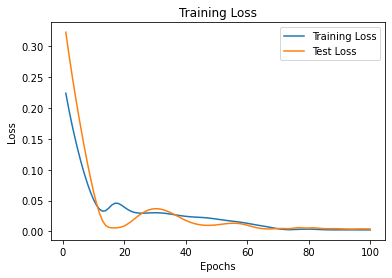

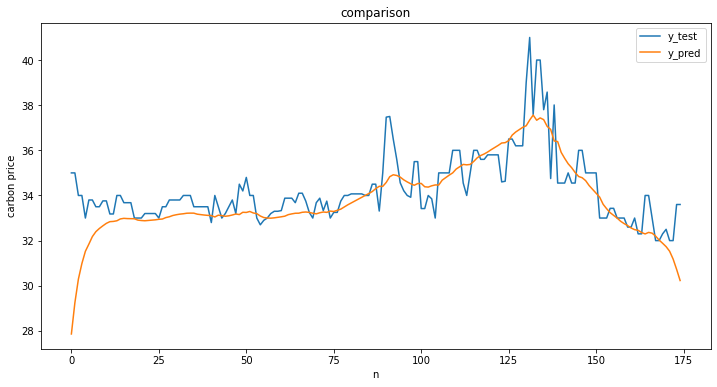

In [3]:
    # 读取数据
    data = pd.read_excel('./tj.xlsx')
    # 归一化数据
    labels = None
    scaler = None
    for column in data.columns:
        scaler_temp = MinMaxScaler()
        data[[column]] = scaler_temp.fit_transform(data[[column]])
        if '碳价' in column:
            scaler = scaler_temp
            labels = data[[column]]
    # 将数据转换为 PyTorch 张量
    data_tensor = torch.tensor(data.values, dtype=torch.float32)
    data_tensor_label = torch.tensor(labels.values, dtype=torch.float32)
    # 初始化模型参数
    input_size = data.shape[1]  # 输入特征维度
    hidden_size = 64  # 隐藏层维度
    output_size = 1  # 输出维度
    # 初始化模型
    models = [
        RNNModel(input_size, hidden_size, output_size),
        GRUModel(input_size, hidden_size, output_size),
        LSTMModel(input_size, hidden_size, output_size),
        BILSTMModel(input_size, hidden_size, output_size)]
    
    # 划分训练集和测试集
    train_size = int(0.8 * len(data_tensor))
    train_data = data_tensor[:train_size]
    test_data = data_tensor[train_size:]
    
    # 准备训练数据和标签
    train_input = train_data[:-1]  # 输入数据为前n-1行
    train_label = data_tensor_label[:train_size][1:].view(-1, 1)  # 标签为后n行的“碳价”列，需要进行reshape
    
    test_input = test_data[:-1]  # 增加一个维度作为批次维度
    test_label = data_tensor_label[train_size:][1:].view(-1, 1)
    test_label_ndarray = test_label.detach().numpy()
    test_label_ndarray = scaler.inverse_transform(test_label_ndarray)
    
    save_predicted_data = [test_label_ndarray.reshape(-1)]
    
    num_epochs = 100
    models_name = ['RNN', 'GRU', 'LSTM', 'BiLSTM']
    for model, model_name in zip(models, models_name):
        print(' model: {}'.format(model_name))
        
        # 定义损失函数和优化器
        criterion = nn.MSELoss() #损失函数曲线(MSE)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # 记录每个epoch的损失和准确率
        train_losses = []
        test_losses = []

        # 开始训练模型
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            output = model(train_input.unsqueeze(1))  # LSTM 模型的输入需要增加一个维度
            loss = criterion(output, train_label)
            loss.backward()
            optimizer.step()
            
            # 计算并记录训练集上的损失
            train_loss = loss.item()
            train_losses.append(train_loss)
            
            # 计算并记录测试集的损失
            with torch.no_grad():
                test_output = model(test_input.unsqueeze(1))
                test_loss = criterion(test_output, test_label)
                test_losses.append(test_loss.item())
    
            if (epoch + 1) % 20 == 0:
                print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item()))
        
        # 绘制损失曲线
        plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
        plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()
        #plt.savefig('./data/model_{}_loss_curves.png'.format(model_name))
        plt.show()
        
        # 保存模型权重
        #torch.save(model.state_dict(), './models/{}_model.pth'.format(model_name))
        
        # # 加载模型权重
        # model.load_state_dict(torch.load('lstm_model.pth'))# 使用模型进行预测
        
        predicted_output_ndarray = model(test_input.unsqueeze(1)).detach().numpy() #预测
        predicted_output_denormalized = scaler.inverse_transform(predicted_output_ndarray)
        
        save_predicted_data.append(predicted_output_denormalized.reshape(-1))
        
        # 可视化预测结果
        plt.figure(figsize=(12, 6))
        plt.plot(test_label_ndarray, label='y_test')
        plt.plot(predicted_output_denormalized, label='y_pred')
        plt.title('comparison')
        plt.ylabel('carbon price')
        plt.xlabel('n')
        plt.legend()
        plt.show()

In [4]:
# 时间步长
n_timestamps = 10

# 创建输入和输出数据集
def create_dataset(data, n_timestamps):
    X, y = [], []
    for i in range(len(data) - n_timestamps):
        X.append(data[i:(i + n_timestamps), :-1])  # 选择特征
        y.append(data[i + n_timestamps, -1])  # 预测目标
    return np.array(X), np.array(y)

# 使用数值数据生成特征和目标
values = data[['rf', 'gbdt','xgboost', '天津碳价']].values
X, y = create_dataset(values, n_timestamps)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("训练集输入形状:", X_train.shape)
print("训练集输出形状:", y_train.shape)
print("测试集输入形状:", X_test.shape)
print("测试集输出形状:", y_test.shape)

训练集输入形状: (696, 10, 3)
训练集输出形状: (696,)
测试集输入形状: (174, 10, 3)
测试集输出形状: (174,)


In [5]:
y_test

array([0.7   , 0.344 , 0.5005, 0.344 , 0.58  , 0.634 , 0.44  , 0.7   ,
       0.71  , 0.5345, 0.3135, 0.79  , 0.35  , 0.35  , 0.45  , 0.35  ,
       0.8   , 0.575 , 0.35  , 0.575 , 0.366 , 0.443 , 0.35  , 0.602 ,
       0.7   , 0.35  , 0.15  , 0.05  , 0.16  , 0.825 , 0.6   , 0.8715,
       0.7   , 0.7   , 0.76  , 0.778 , 0.6   , 0.344 , 0.7   , 0.531 ,
       0.625 , 0.65  , 0.45  , 0.344 , 0.67  , 0.35  , 0.35  , 0.4345,
       0.65  , 0.74  , 0.3   , 0.75  , 0.76  , 0.585 , 0.35  , 0.634 ,
       0.75  , 0.366 , 0.45  , 0.35  , 0.54  , 0.37  , 0.1   , 0.7   ,
       0.7545, 0.675 , 0.35  , 0.571 , 0.8905, 0.45  , 0.375 , 0.7   ,
       0.443 , 0.61  , 0.4   , 0.3   , 0.67  , 0.3   , 0.35  , 0.6   ,
       0.35  , 0.6055, 0.65  , 0.35  , 0.46  , 0.6   , 0.875 , 0.71  ,
       0.35  , 0.35  , 0.7   , 0.3   , 0.35  , 0.75  , 0.7   , 0.55  ,
       0.325 , 0.75  , 0.7   , 0.67  , 0.35  , 0.35  , 0.67  , 0.634 ,
       0.3   , 0.615 , 0.778 , 0.575 , 0.65  , 0.443 , 0.75  , 0.6155,
      

Epoch 1/50
20/20 [==============================] - 2s 17ms/step - loss: 0.0852 - val_loss: 0.0485
Epoch 2/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0485 - val_loss: 0.0320
Epoch 3/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0331 - val_loss: 0.0191
Epoch 4/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0256 - val_loss: 0.0180
Epoch 5/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0221 - val_loss: 0.0186
Epoch 6/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0218 - val_loss: 0.0179
Epoch 7/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0194 - val_loss: 0.0174
Epoch 8/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0192 - val_loss: 0.0186
Epoch 9/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0178 - val_loss: 0.0197
Epoch 10/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0194 - val_loss: 0.0178
Epoch 11/50
20/20 

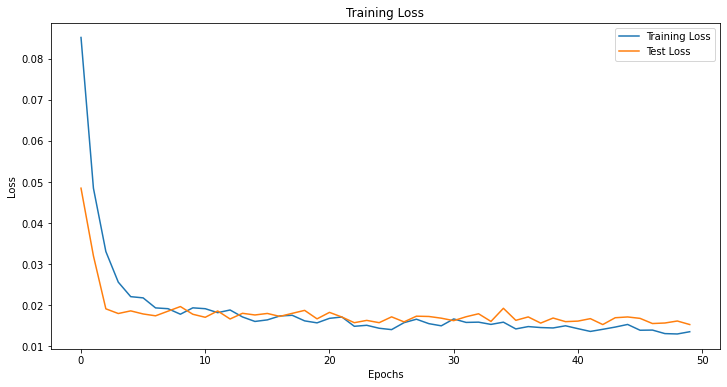

6/6 [==============================] - 0s 2ms/step
平均绝对误差（MAE）: 0.09358772222680607
均方误差（MSE）: 0.014356212264751008
均方根差（RMSE）: 0.11981741219351638
平均绝对百分比误差（MAPE）: 0.78016144315144


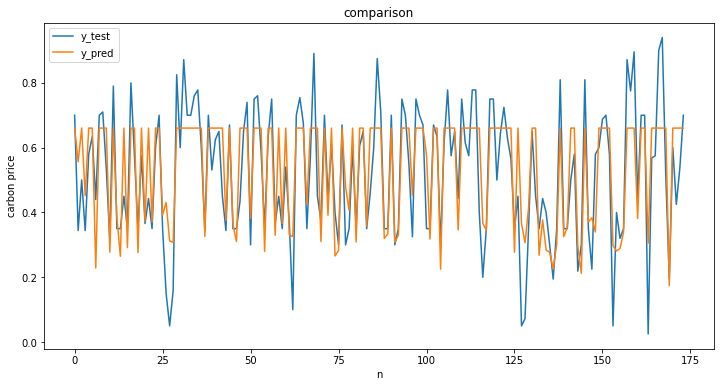

In [6]:
# 创建 Group-CNN 模型
def create_group_cnn_model(input_shape):
    inputs = Input(shape=input_shape)

    # 第一组卷积
    x = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu')(inputs)
    x = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu')(x)

    # 第二组卷积
    x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x) #维度与输入个数无关！

    # 扁平化和全连接层
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)  # 输出层

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# 创建模型
model = create_group_cnn_model((X_train.shape[1], X_train.shape[2])) #维度与输入个数无关！


# 训练模型
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# 评估模型
loss = model.evaluate(X_test, y_test, verbose=0)
#print(f"测试集均方误差: {loss:.4f}")

# 可视化训练历史
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# 模型预测
y_pred = model.predict(X_test)

# 平均绝对误差（Mean Absolute Error, MAE）
mae = mean_absolute_error(y_test, y_pred)
print("平均绝对误差（MAE）:", mae)
# 均方误差（Mean Squared Error, MSE）
mse = mean_squared_error(y_test, y_pred)
print("均方误差（MSE）:", mse)
rmse = np.sqrt(mse)
print("均方根差（RMSE）:", rmse)
# 平均绝对百分比误差（Mean Absolute Percentage Error, MAPE）
mape = np.abs((y_test - y_pred) / y_test).mean()
print("平均绝对百分比误差（MAPE）:", mape)

# 可视化预测结果
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.title('comparison')
plt.ylabel('carbon price')
plt.xlabel('n')
plt.legend()
plt.show()
